In [ ]:
import pandas as pd
import numpy as np
from random import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("./clean_kaggle_data_2022.csv", low_memory = False, encoding = 'latin2')
df.shape

(8137, 298)

In [ ]:
df.drop(df.index[0], inplace=True)

### multi-col

In [ ]:
multi_col_names = [col for col in df.columns if "_" in col]
# rm 'Q29_Encoded','Q29_buckets' from multi_col_names
multi_col_names.remove('Q29_Encoded')
multi_col_names.remove('Q29_buckets')
df[multi_col_names] = df[multi_col_names].notna().astype(int)

In [ ]:
print("multi col:, len:", len(multi_col_names),"\n")
print(multi_col_names)

multi col:, len: 277 

['Q6_1', 'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q6_6', 'Q6_7', 'Q6_8', 'Q6_9', 'Q6_10', 'Q6_11', 'Q6_12', 'Q7_1', 'Q7_2', 'Q7_3', 'Q7_4', 'Q7_5', 'Q7_6', 'Q7_7', 'Q10_1', 'Q10_2', 'Q10_3', 'Q12_1', 'Q12_2', 'Q12_3', 'Q12_4', 'Q12_5', 'Q12_6', 'Q12_7', 'Q12_8', 'Q12_9', 'Q12_10', 'Q12_11', 'Q12_12', 'Q12_13', 'Q12_14', 'Q12_15', 'Q13_1', 'Q13_2', 'Q13_3', 'Q13_4', 'Q13_5', 'Q13_6', 'Q13_7', 'Q13_8', 'Q13_9', 'Q13_10', 'Q13_11', 'Q13_12', 'Q13_13', 'Q13_14', 'Q14_1', 'Q14_2', 'Q14_3', 'Q14_4', 'Q14_5', 'Q14_6', 'Q14_7', 'Q14_8', 'Q14_9', 'Q14_10', 'Q14_11', 'Q14_12', 'Q14_13', 'Q14_14', 'Q14_15', 'Q14_16', 'Q15_1', 'Q15_2', 'Q15_3', 'Q15_4', 'Q15_5', 'Q15_6', 'Q15_7', 'Q15_8', 'Q15_9', 'Q15_10', 'Q15_11', 'Q15_12', 'Q15_13', 'Q15_14', 'Q15_15', 'Q17_1', 'Q17_2', 'Q17_3', 'Q17_4', 'Q17_5', 'Q17_6', 'Q17_7', 'Q17_8', 'Q17_9', 'Q17_10', 'Q17_11', 'Q17_12', 'Q17_13', 'Q17_14', 'Q17_15', 'Q18_1', 'Q18_2', 'Q18_3', 'Q18_4', 'Q18_5', 'Q18_6', 'Q18_7', 'Q18_8', 'Q18_9', 'Q18_10'

### single-col

In [ ]:
single_col_names = [col for col in df.columns if "_" not in col]
single_col_names.append("Q29_Encoded")
single_col_names.remove('Q29')
nan_rates = df[single_col_names].isnull().sum() * 100 / len(df)
fillout_col_names = []
drop_col_names =[]
for i,(col, rate) in enumerate(nan_rates.items()):
    if rate == 0:
      continue
    elif rate < 10:
        mode_value = df[col].mode()[0]  # Get the most frequent value
        fillout_col_names.append([col, mode_value])
        df[col].fillna(mode_value, inplace=True)
    else:
      drop_col_names.append(col)
print("single col:, len:", single_col_names, len(single_col_names),"\n")
print("fill col with mode for nan rate<10: ",fillout_col_names,'\n')
print("drop col:", drop_col_names, '\n')

single col:, len: ['Duration (in seconds)', 'Q2', 'Q3', 'Q4', 'Q5', 'Q8', 'Q9', 'Q11', 'Q16', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q30', 'Q32', 'Q43', 'Q29_Encoded'] 19 

fill col with mode for nan rate<10:  [['Q16', 'Under 1 year'], ['Q30', '$0 ($USD)']] 

drop col: ['Q9', 'Q22', 'Q32', 'Q43'] 



#### encode cat single col

In [ ]:
single_cat_names = [col for col in single_col_names if col not in drop_col_names]
single_cat_names.remove('Duration (in seconds)')
single_cat_names.remove('Q29_Encoded')
single_cat_names.remove('Q26') # value not parsed correctly
single_cat_names.remove('Q5') # answer all No

print(single_cat_names)
print(len(single_cat_names))

['Q2', 'Q3', 'Q4', 'Q8', 'Q11', 'Q16', 'Q23', 'Q24', 'Q25', 'Q27', 'Q30']
11


In [ ]:
top_10_countries = df['Q4'].value_counts().nlargest(10).index
# Overwrite Q4: Keep top 10 countries, replace others with "Other"
df['Q4'] = df['Q4'].apply(lambda x: x if x in top_10_countries else 'Other')

In [ ]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# Define categorical columns
ordinal_vars = ['Q2', 'Q11', 'Q16', 'Q25', 'Q27', 'Q30']  # Ordered categories
onehot_vars = ['Q3', 'Q4', 'Q8', 'Q23', 'Q24']  # Unordered categories

# Step 2: Apply Ordinal Encoding for ordered variables
ordinal_mappings = {
    'Q2': ['18-21', '22-24', '25-29', '30-34', '35-39', '40-44', '45-49',
           '50-54', '55-59', '60-69', '70+'],

    'Q11': ['I have never written code', '< 1 years', '1-3 years', '3-5 years',
            '5-10 years', '10-20 years', '20+ years'],

    'Q16': ['I do not use machine learning methods', 'Under 1 year', '1-2 years', '2-3 years', '3-4 years',
            '4-5 years', '5-10 years', '10-20 years'],

    'Q25': ['0-49 employees', '50-249 employees', '250-999 employees', '1000-9,999 employees', '10,000 or more employees'],

    'Q27': ['I do not know','No (we do not use ML methods)', 'We are exploring ML methods (and may one day put a model into production)',
            'We use ML methods for generating insights (but do not put working models into production)',
            'We recently started using ML methods (i.e., models in production for less than 2 years)',
            'We have well established ML methods (i.e., models in production for more than 2 years)', ],

    'Q30': ['$0 ($USD)', '$1-$99', '$100-$999', '$1000-$9,999', '$10,000-$99,999', '$100,000 or more ($USD)']
}

# Apply Ordinal Encoding
encoder = OrdinalEncoder(categories=[ordinal_mappings[col] for col in ordinal_vars])
df[ordinal_vars] = encoder.fit_transform(df[ordinal_vars])

# Step 3: Apply One-Hot Encoding for nominal variables
dummies_df = pd.get_dummies(df[onehot_vars], prefix=onehot_vars, drop_first=True).astype(int) # first cat as baseline

# Step 4: Concatenate the new dummy features with the original dataframe
df_encoded = pd.concat([df, dummies_df], axis=1)

# Step 5: Drop the original categorical feature columns
df_encoded = df_encoded.drop(columns=onehot_vars)

### drop df

In [ ]:
df_encoded.drop(columns=drop_col_names, inplace=True)
df_encoded.drop(columns=['Q5', 'Duration (in seconds)','Q26'], inplace=True)
print(len(df_encoded.columns))

332


# Question 1: Data Cleaning

###**Drop the target variable(s) and get the target variable**

In [ ]:
salaries = df_encoded

In [ ]:
# Make sure there are no missing values remaining in the dataset
assert salaries.isnull().values.sum() == 0, \
    "There are still {} missing values remaining in salaries!".format(
        salaries.isnull().values.sum()
    )

In [ ]:
target = salaries['Q29_Encoded']
#TODO: Drop the target variables from the feature set
salaries = salaries.drop(columns=['Q29_Encoded','Q29', 'Q29_buckets'])

# Make sure the target variables are not included in the feature set
for col in salaries.columns:
    assert 'Q29' not in col, \
        "Target variable ({}) is still in the dataset".format(col)

# Question 2: feature selection

### split data

In [ ]:
# You can use from sklearn.model_selection.train_test_split()
from sklearn.model_selection import train_test_split
train_df, test_df, y_train, y_test = train_test_split(salaries, target, test_size=0.2, random_state=42)

### feature importance plot

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Train Random Forest Regressor for ordinal prediction
model = RandomForestRegressor(random_state=42)
model.fit(train_df, y_train)

# Get feature importances
importances = model.feature_importances_


In [ ]:
# sort
indices = importances.argsort()[::-1]
feature_importance_df = pd.DataFrame({'Feature': train_df.columns[indices], 'Importance': importances[indices]})

In [ ]:
for feature, importance in zip(feature_importance_df["Feature"], feature_importance_df["Importance"]):
    print(f"{feature}: {importance}")

Q4_United States of America: 0.34200300715989873
Q11: 0.07450613512053476
Q16: 0.05342304636520885
Q27: 0.03893711823803506
Q2: 0.030708394285159243
Q30: 0.02798969867542614
Q25: 0.018469866758945463
Q4_India: 0.012198345052448458
Q23_Manager (Program, Project, Operations, Executive-level, etc): 0.008442053152230778
Q4_United Kingdom of Great Britain and Northern Ireland: 0.007349287961831468
Q8_MasterEEs degree: 0.005193446006814429
Q28_3: 0.005088909281227546
Q34_3: 0.004373190527047845
Q3_Woman: 0.0037578650155120743
Q44_8: 0.0037019533792701466
Q28_1: 0.003601035427129738
Q23_Other: 0.0035329771253182645
Q24_Computers/Technology: 0.003346861611697134
Q24_Accounting/Finance: 0.0031139342118233874
Q6_1: 0.0030608967737299955
Q24_Other: 0.0030285633130279067
Q40_8: 0.0030225325271601797
Q10_3: 0.0030199213207126622
Q21_8: 0.003019032356524751
Q44_4: 0.003011799707751561
Q44_1: 0.002940967381761566
Q7_4: 0.002920389864880193
Q44_7: 0.0029163835987159213
Q7_2: 0.0028873379334760415
Q

In [ ]:
# Group by the prefix before the first underscore (_) to sum importance scores
feature_importance_df['Category'] = feature_importance_df['Feature'].str.split('_').str[0]  # Extract main category
grouped_importance = feature_importance_df.groupby('Category')['Importance'].sum().reset_index()

# Sort and display
grouped_importance = grouped_importance.sort_values(by='Importance', ascending=False)
print(grouped_importance)

   Category  Importance
28       Q4    0.370434
1       Q11    0.074506
6       Q16    0.053423
16      Q27    0.038937
10       Q2    0.030708
19      Q30    0.027990
13      Q23    0.027751
14      Q24    0.026192
32      Q44    0.026087
3       Q13    0.023346
2       Q12    0.023202
33       Q6    0.022458
17      Q28    0.022396
7       Q17    0.020531
8       Q18    0.019858
15      Q25    0.018470
23      Q35    0.018131
5       Q15    0.016697
34       Q7    0.016343
35       Q8    0.012742
12      Q21    0.012669
4       Q14    0.011343
22      Q34    0.010799
29      Q40    0.010461
20      Q31    0.009671
24      Q36    0.008361
25      Q37    0.006654
9       Q19    0.006260
0       Q10    0.005657
18       Q3    0.005639
21      Q33    0.005336
26      Q38    0.004158
27      Q39    0.003998
11      Q20    0.003291
31      Q42    0.003001
30      Q41    0.002500


In [ ]:
print(len(grouped_importance)) # 44allq - 4dropna - 4drop = 36

36


### feature selection by regulation

In [ ]:
#train_df, test_df, y_train, y_test
model = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)
model.fit(train_df, y_train)
selected_features = np.array(train_df.columns)[model.coef_[0] != 0]
print("Selected Features:", selected_features)

Selected Features: ['Q2' 'Q6_1' 'Q6_3' 'Q6_6' 'Q6_7' 'Q6_12' 'Q7_1' 'Q7_3' 'Q10_1' 'Q10_3'
 'Q11' 'Q12_1' 'Q12_2' 'Q12_4' 'Q12_6' 'Q12_7' 'Q12_8' 'Q12_9' 'Q12_10'
 'Q12_15' 'Q13_1' 'Q13_3' 'Q13_4' 'Q13_6' 'Q13_10' 'Q13_11' 'Q14_2'
 'Q14_12' 'Q15_1' 'Q15_2' 'Q15_9' 'Q16' 'Q17_2' 'Q17_3' 'Q17_6' 'Q17_7'
 'Q18_2' 'Q18_3' 'Q18_4' 'Q18_6' 'Q18_9' 'Q19_2' 'Q19_3' 'Q21_2' 'Q21_3'
 'Q21_8' 'Q21_10' 'Q25' 'Q27' 'Q28_1' 'Q28_3' 'Q28_4' 'Q28_5' 'Q28_6'
 'Q28_7' 'Q28_8' 'Q30' 'Q31_1' 'Q31_2' 'Q31_3' 'Q31_4' 'Q31_12' 'Q34_3'
 'Q35_1' 'Q35_2' 'Q35_5' 'Q35_8' 'Q35_9' 'Q35_10' 'Q35_13' 'Q37_12'
 'Q40_14' 'Q42_1' 'Q44_3' 'Q44_4' 'Q44_5' 'Q44_6' 'Q44_8' 'Q44_9' 'Q44_12'
 'Q3_Woman' 'Q4_France' 'Q4_India' 'Q4_Nigeria' 'Q4_Other' 'Q4_Spain'
 'Q4_United Kingdom of Great Britain and Northern Ireland'
 'Q4_United States of America' 'Q8_I prefer not to answer'
 'Q8_Master\x81E\x80\x81Es degree'
 'Q23_Data Analyst (Business, Marketing, Financial, Quantitative, etc)'
 'Q23_Data Scientist'
 'Q23_Manager (Program

### filter df to only selected features

In [ ]:
train_df_selected = train_df[selected_features]
test_df_selected = test_df[selected_features]

# Question 3: Model Implementation

## Implement Ordinal Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

class OrdinalLogisticRegression():
    # TODO: Add ordinal logreg hyperparameters as args to __init__
    # A dummy hyperparameter is put as a placeholder for now
    # def __init__(self, max_iter=100, hyperparameter='dummy'):
    #     self.hyperparameter = hyperparameter #TODO
    #     self.max_iter = max_iter

    #     self.classes_ = []
    #     self.models_ = []

    def __init__(self, max_iter=100, C=1.0, solver='lbfgs', tol=1e-4):
        self.max_iter = max_iter
        self.classes_ = []
        self.models_ = []
        self.C = C
        self.solver = solver
        self.tol = tol

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        self.models_ = []

        # Train k-1 binary logistic regression models
        for i, c in enumerate(self.classes_[:-1]): # We need only k-1 classifiers
            y_i = (y > c).astype(int)  # TODO: label is 0 if the salary bucket is 0 to c, otherwise label is 1
            model = LogisticRegression(max_iter=self.max_iter)  # TODO: what machine learning model should be here?
            model.fit(X, y_i)
            self.models_.append(model)

        return self

    def predict_proba(self, X):
        assert len(self.models_) > 0, "Model is not fitted yet. Run .fit() first."

        # Predicted probabilities for k-1 binary logistic regression models (initialize placeholders)
        binary_probabilities = np.empty((X.shape[0], len(self.models_), 2), dtype=float)

        # Make predictions of k-1 binary logistic regression models
        for i, model in enumerate(self.models_):
            binary_probabilities[:, i] = model.predict_proba(X) #TODO: predicted **probabilities** by the ith binary logistic regression model

        # Compute the probabilities to be in each class
        k = len(self.classes_)
        proba = np.empty((X.shape[0], k), dtype=float) # predicted probabilities for all the data in X (shape=(X.shape[0], k))

        proba[:, 0] = binary_probabilities[:, 0, 0] # 0th probability

        for i in range(1, k-1):
            # ith probability
            # (prob of belonging to class 0 for the ith model - prob of belonging to class 0 for the (i-1)th model
            proba[:, i] = binary_probabilities[:, i, 0] - binary_probabilities[:, i-1, 0]

        proba[:, -1] = binary_probabilities[:, k-2, 1] # (k-1)th probability

        assert (proba.sum(axis=1) == 1).all(), \
            'There is a problem in the probability computation'
        return proba

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis = 1)

    # Add hyperparameters here whenever you add new ones
    # max_iter is added as an example here. key is the hyperparameter name,
    # and value is the attribute name you defined in this class
    def get_params(self, deep=True):
        return {'max_iter': self.max_iter}

    # DO NOT CHANGE
    def set_params(self, **parameters):
        # Set estimator parameters
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

## Run k-fold cross validation

- Report the average/variance of accuracies across folds

### scale

In [ ]:
from sklearn.preprocessing import StandardScaler
feature_names = train_df.columns

scaler = StandardScaler()
train_df = scaler.fit_transform(train_df)
test_df = scaler.transform(test_df)
# convert y to numpy
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### mse

In [ ]:
model = OrdinalLogisticRegression()
kfold = KFold(n_splits=10)
mse_scores = []
# train_df, test_df, y_train, y_test = train_test_split()
# Perform 10-fold cross-validation on the training set
for train_idx, val_idx in kfold.split(train_df):
    X_train, X_val = train_df[train_idx], train_df[val_idx]
    y_train_fold, y_val = y_train[train_idx], y_train[val_idx]

    # Train model
    model.fit(X_train, y_train_fold)

    # Predict
    predictions = model.predict(X_val)

    mse = mean_squared_error(y_val, predictions)
    mse_scores.append(mse)

    print(f"Fold {len(mse_scores)}: MSE: {round(mse, 3)}")

# Compute average and variance

print("Average MSE    :", np.mean(mse_scores))
print("Variance of MSE:", np.var(mse_scores))

Fold 1: MSE: 13.367
Fold 2: MSE: 13.243
Fold 3: MSE: 10.731
Fold 4: MSE: 14.034
Fold 5: MSE: 14.081
Fold 6: MSE: 11.931
Fold 7: MSE: 14.455
Fold 8: MSE: 12.295
Fold 9: MSE: 12.306
Fold 10: MSE: 11.269
Average MSE    : 12.77120973650006
Variance of MSE: 1.4289197025238862


## Bias-variance trade-off

[bias_variance_decomp.py](https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/bias_variance_decomp.py)

Below is a function you can use to compute the bias and variance of your ordinal logistic regression model. Using this function, analyze the ordinal logistic regression model performance based on bias-variance trade-off.

### tradeoff def

In [ ]:
### NOTE: You don't need to change anything in this code block! ###

def _draw_bootstrap_sample(rng, X, y):
    sample_indices = np.arange(X.shape[0])
    bootstrap_indices = rng.choice(
        sample_indices, size=sample_indices.shape[0], replace=True
    )
    return X[bootstrap_indices], y[bootstrap_indices]

def bias_variance_decomp(
    estimator,
    X_train,
    y_train,
    X_test,
    y_test,
    num_rounds=10,
    random_seed=0
):
    """
    estimator : object
        A classifier or regressor object or class implementing both a
        `fit` and `predict` method similar to the scikit-learn API.

    X_train : array-like, shape=(num_examples, num_features)
        A training dataset for drawing the bootstrap samples to carry
        out the bias-variance decomposition.

    y_train : array-like, shape=(num_examples)
        Targets (class labels, continuous values in case of regression)
        associated with the `X_train` examples.

    X_test : array-like, shape=(num_examples, num_features)
        The test dataset for computing the average loss, bias,
        and variance.

    y_test : array-like, shape=(num_examples)
        Targets (class labels, continuous values in case of regression)
        associated with the `X_test` examples.

    num_rounds : int (default=10)
        Number of bootstrap rounds (sampling from the training set)
        for performing the bias-variance decomposition. Each bootstrap
        sample has the same size as the original training set.

    random_seed : int (default=0)
        Random seed for the bootstrap sampling used for the
        bias-variance decomposition.

    Returns
    ----------
    avg_bias, avg_var : returns the average bias, and average bias (all floats),
                        where the average is computed over the data points
                        in the test set.

    """
    loss = "mse"

    for ary in (X_train, y_train, X_test, y_test):
        assert type(ary) == np.ndarray, \
            "X_train, y_train, X_test, y_test have to be NumPy array. \
            If e.g., X_train is a pandas DataFrame, convert it to NumPy array \
            via X_train=X_train.values."

    rng = np.random.RandomState(random_seed)

    # All the predictions across different rounds
    all_pred = np.zeros((num_rounds, y_test.shape[0]), dtype=np.float64)

    for i in range(num_rounds):
        # Randomly sample training data
        X_boot, y_boot = _draw_bootstrap_sample(rng, X_train, y_train)

        # Fit the model using the randomly sampled data
        pred = estimator.fit(X_boot, y_boot).predict(X_test)
        all_pred[i] = pred

    # Mean prediction across runs using different dataset for each data point
    main_predictions = np.mean(all_pred, axis=0)

    # Average bias across different rounds
    avg_bias = np.sum((main_predictions - y_test) ** 2) / y_test.size

    # Average variance across different rounds
    avg_var = np.sum((main_predictions - all_pred) ** 2) / all_pred.size

    return avg_bias, avg_var

### run tradeoff

In [ ]:
# # Usage example
# model = OrdinalLogisticRegression()
# avg_bias, avg_var = \
#     bias_variance_decomp(model, X_train, y_train, X_test, y_test, num_rounds=10, random_seed=0)

In [ ]:
# train_df, test_df, y_train, y_test = train_test_split()

# Initialize model
model = OrdinalLogisticRegression()

# Compute bias and variance using bootstrapping
avg_bias, avg_var = bias_variance_decomp(
    model, train_df, y_train, test_df, y_test, num_rounds=10, random_seed=0
)

# Print results
print(f"Average Bias: {avg_bias:.4f}")
print(f"Average Variance: {avg_var:.4f}")

Average Bias: 9.4016
Average Variance: 3.4801


In [ ]:
#TODO: Discuss bias-variance trade-off of your ordinal logistic regression model

# Question 4: Model Tuning

- What are the hyperparameters we can potentially set for our ordinal logistic regression model?
- Which hyperparameters seem to be worthwhile to tune?

## Grid Search

- Grid search will take time to complete - but if it does not finish in a few hours, you're probably trying too many combinations
- A recommended approach is to try a small number of combinations with a wide range first (for continuous value hyperparameters)! Then gradually increase the points that seem to be near optimal

In [ ]:
from sklearn.model_selection import GridSearchCV
# {'C': 0.01, 'solver': 'newton-cg'}

#TODO: Perform grid search using a proper criteria and identify the best parameter set

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'saga']
}

grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(train_df, y_train)

print("Best parameters:", grid.best_params_)
print("Best MSE:", grid.best_score_)


Best parameters: {'C': 0.01, 'solver': 'newton-cg'}
Best MSE: -12.846522526096553


In [ ]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
best_C = None
best_bias_variance = float("inf")

for C in C_values:

    model = OrdinalLogisticRegression(C=C)

    avg_bias, avg_var = bias_variance_decomp(
    model, train_df, y_train, test_df, y_test, num_rounds=10, random_seed=0)

    print(f"C: {C}, Bias: {avg_bias:.4f}, Variance: {avg_var:.4f}, Total: {avg_bias + avg_var:.4f}")

    if avg_bias + avg_var < best_bias_variance:
        best_bias_variance = avg_bias + avg_var
        best_C = C

print(f"Best C based on Bias-Variance Tradeoff: {best_C}")

C: 0.001, Bias: 9.4016, Variance: 3.4801, Total: 12.8818
C: 0.01, Bias: 9.4016, Variance: 3.4801, Total: 12.8818
C: 0.1, Bias: 9.4016, Variance: 3.4801, Total: 12.8818
C: 1, Bias: 9.4016, Variance: 3.4801, Total: 12.8818
C: 10, Bias: 9.4016, Variance: 3.4801, Total: 12.8818
C: 100, Bias: 9.4016, Variance: 3.4801, Total: 12.8818
Best C based on Bias-Variance Tradeoff: 0.001


## Visualize the feature importance of your model

### def best model

In [ ]:
best_model = OrdinalLogisticRegression(C=1, solver="newton-cg") #TODO: set the best-performing hyperparameters identified via grid search
best_model = model.fit(train_df, y_train)

### best model feature visual

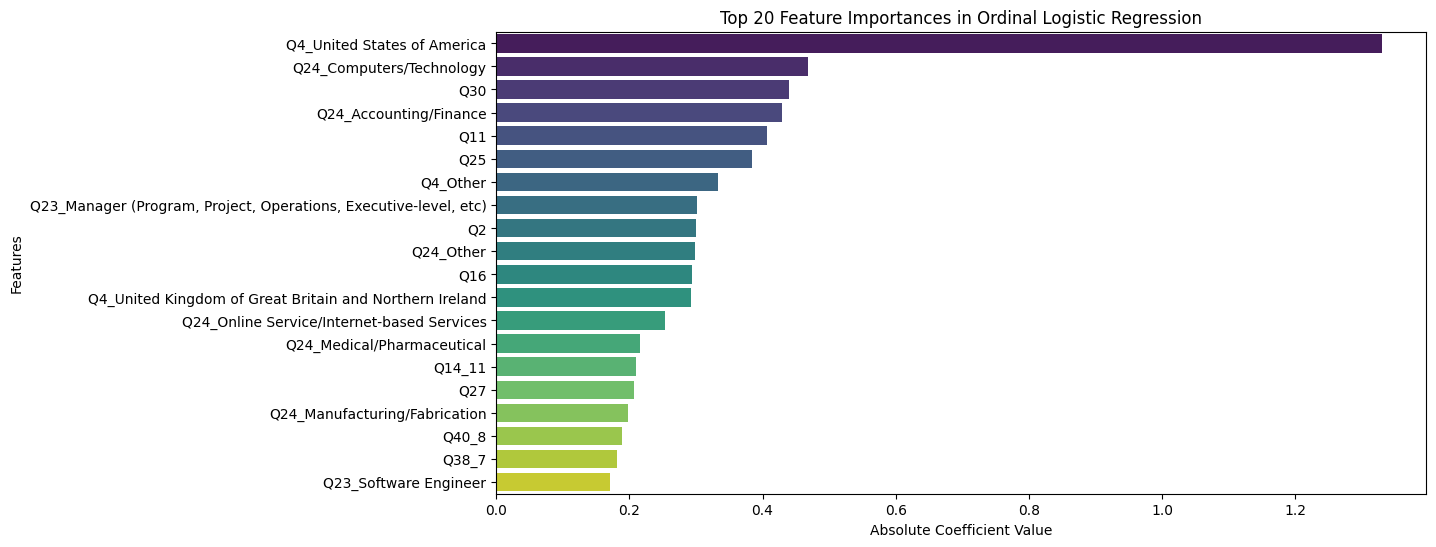

In [ ]:
#TODO: Visualize feature importance of the ordinal logistic regression model
# feature_names = train_df.columns

# Extract coefficients from all binary logistic models
coefs = np.mean([m.coef_[0] for m in model.models_], axis=0)  # Average across models

# Create a DataFrame
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(coefs)})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df[:20], palette="viridis")  # Top 20 features
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Features")
plt.title("Top 20 Feature Importances in Ordinal Logistic Regression")
plt.show()

# Question 5: Testing

In [ ]:
#TODO: Using the best-performing model, evaluate the model performance both on the training set and test set
from sklearn.metrics import accuracy_score, classification_report

y_train_pred = best_model.predict(train_df)
y_test_pred = best_model.predict(test_df)

# Compute MSE
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")

Train MSE: 9.3485
Test MSE: 11.9386


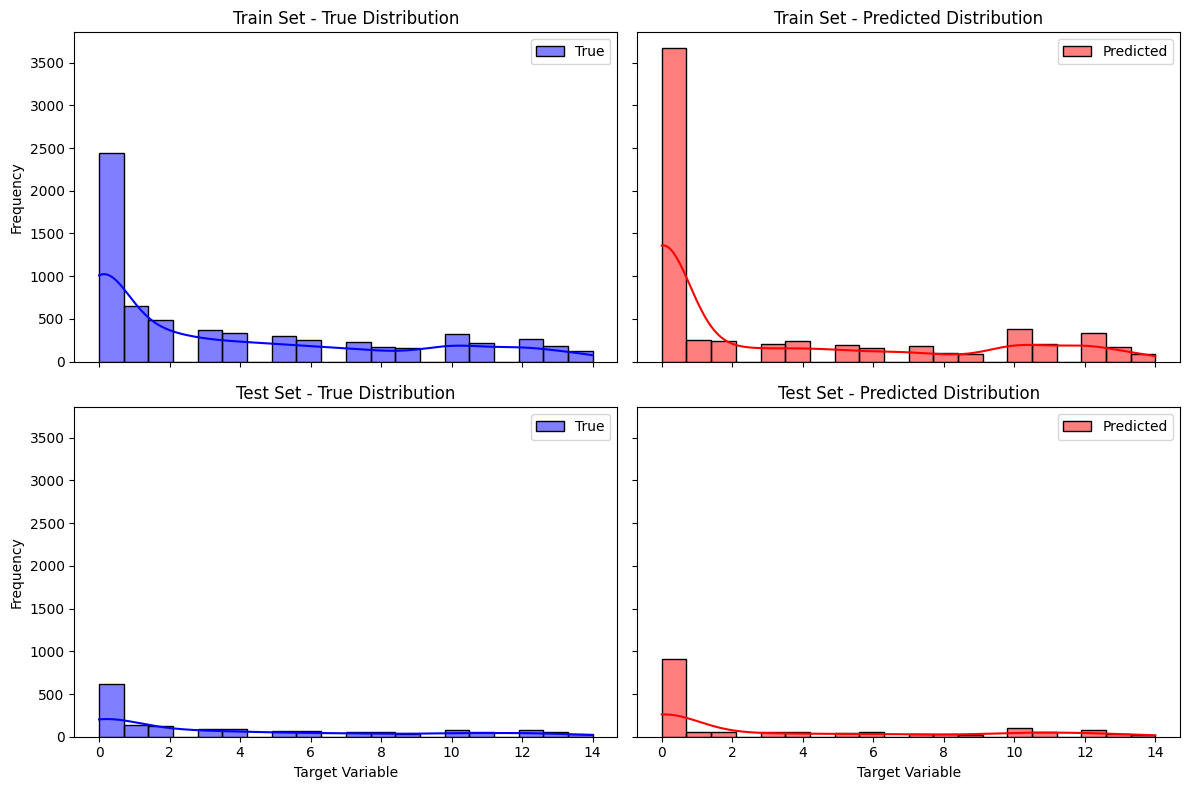

In [ ]:
#TODO: Plot the distribution of true target variable values and their predictions on both the training set and test set


# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# Plot true vs predicted distribution for training set
sns.histplot(y_train, bins=20, kde=True, ax=axes[0, 0], color="blue", label="True")
sns.histplot(y_train_pred, bins=20, kde=True, ax=axes[0, 1], color="red", label="Predicted")

# Plot true vs predicted distribution for test set
sns.histplot(y_test, bins=20, kde=True, ax=axes[1, 0], color="blue", label="True")
sns.histplot(y_test_pred, bins=20, kde=True, ax=axes[1, 1], color="red", label="Predicted")

# Set titles
axes[0, 0].set_title("Train Set - True Distribution")
axes[0, 1].set_title("Train Set - Predicted Distribution")
axes[1, 0].set_title("Test Set - True Distribution")
axes[1, 1].set_title("Test Set - Predicted Distribution")

# Set labels
for ax in axes.flat:
    ax.set_xlabel("Target Variable")
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.show()